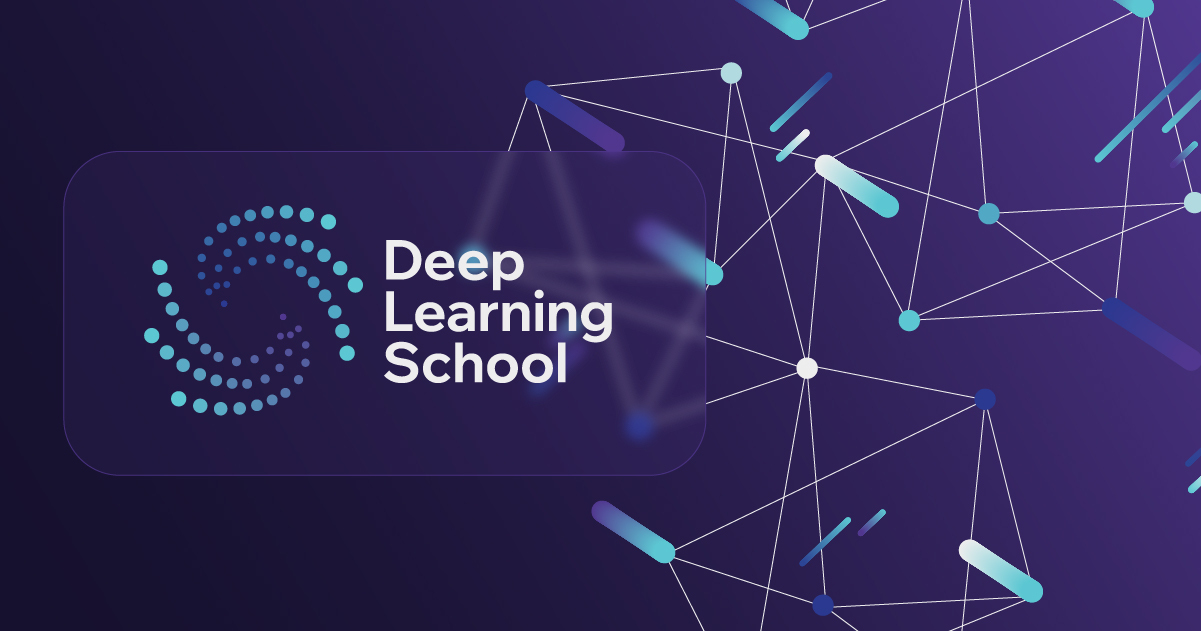

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h1 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h1>



В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader
import random

sns.set(style="darkgrid", font_scale=1.4)

ModuleNotFoundError: No module named 'sklearn'

In [3]:
# Reduce stochasticity

SEED = 42

# PyTorch
torch.manual_seed(SEED)

# CUDA (GPU)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups

# NumPy
np.random.seed(SEED)

# Python's built-in random
random.seed(SEED)

In [4]:
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(True)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [5]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

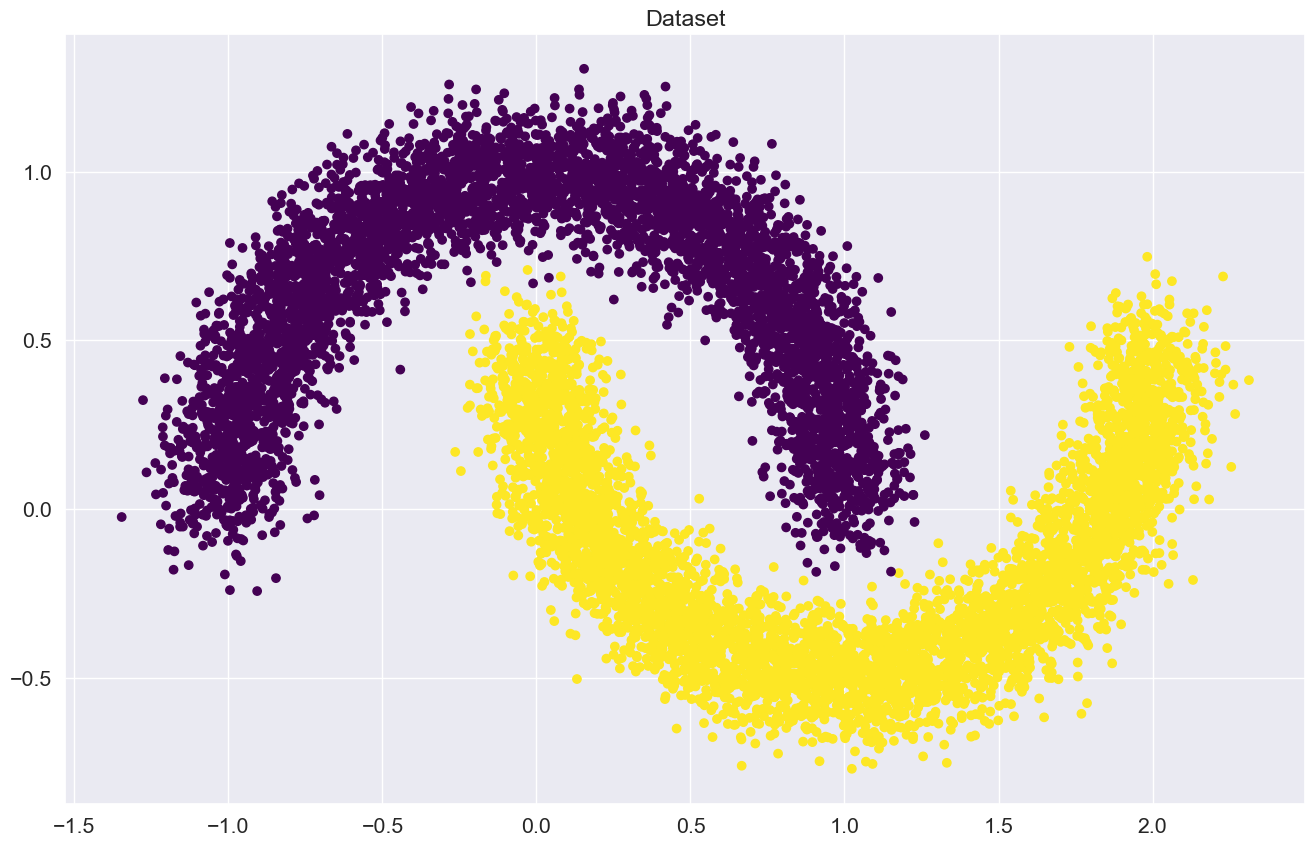

In [6]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [8]:
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val)

Создаем `Dataset` и `DataLoader`.

In [9]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к классу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидой. Чаще всего в качестве сигмоида берут:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [10]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = torch.matmul(x, self.weights.t())
        if self.bias:
            x +=  self.bias_term
        return x

In [11]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

**Ответ:**

In [12]:
2*1 + 1


3

### Train loop

Перейдём непосредственно к обучению.

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обнуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [13]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss = loss_function(outp, y_batch.unsqueeze(1))
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.5625
Iteration: 100
Batch accuracy: 0.796875
Iteration: 200
Batch accuracy: 0.8125
Iteration: 300
Batch accuracy: 0.8984375
Iteration: 400
Batch accuracy: 0.875
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.828125

Iteration: 755.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся? (ваш ответ может варьироваться в зависимости от запуска)

**Ответ:**

700

### Визуализируем результаты

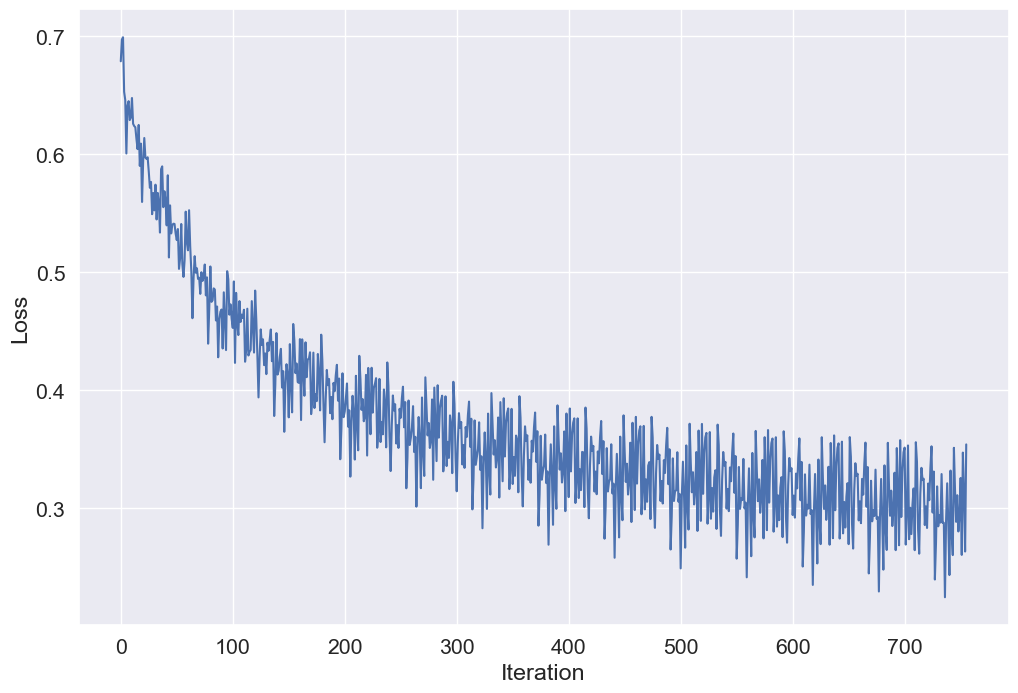

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

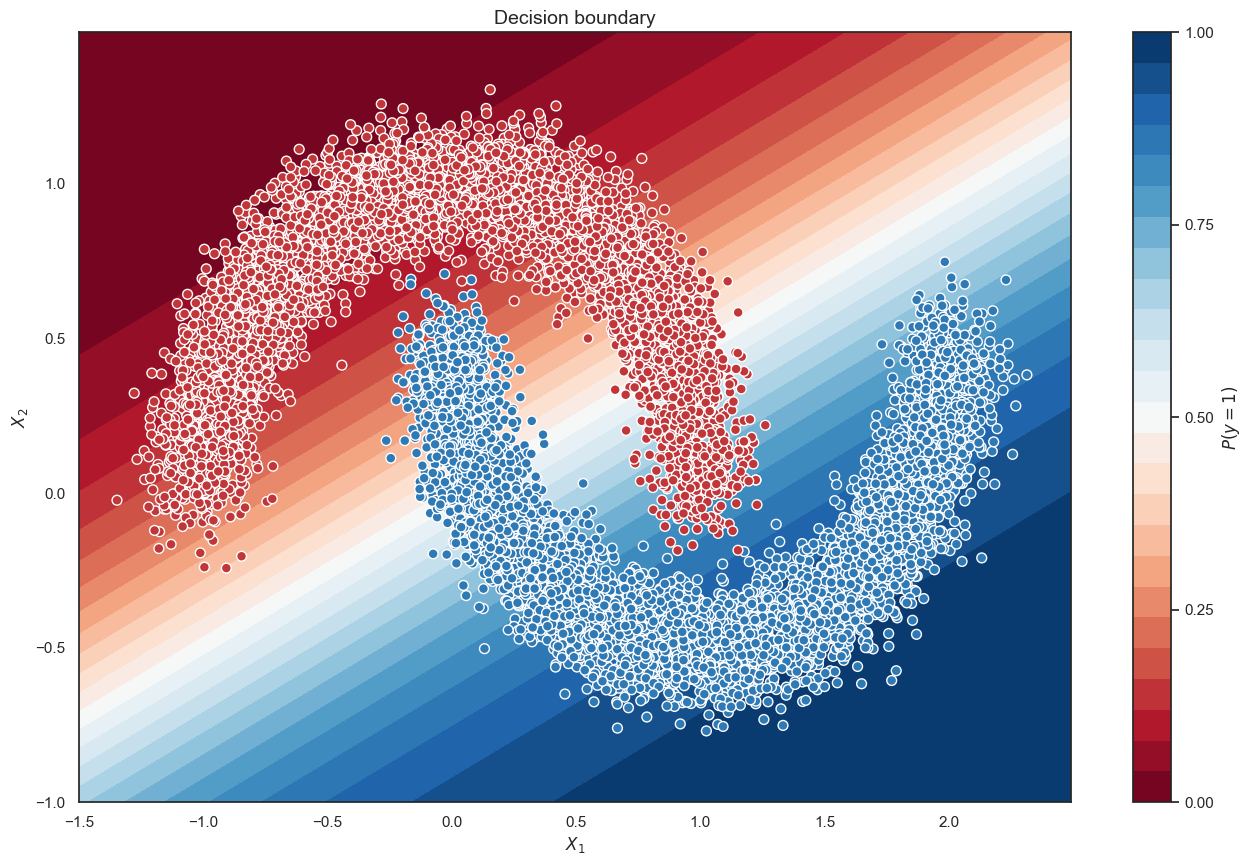

In [15]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [16]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [17]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, predict(val_dataloader, linear_regression))

0.862

**Вопрос 3**

Какое `accuracy` получается после обучения? (ваш ответ может варьироваться в зависимости от запуска)

**Ответ:**

0.8648

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [18]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs
from torch.utils.data import DataLoader

# Параметры DataLoader
BATCH_SIZE = 128  # Стандартный размер батча для MNIST
NUM_WORKERS = 2   # Количество подпроцессов для загрузки данных

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

# Создание DataLoader
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,          # Перемешивание данных для обучения
    num_workers=NUM_WORKERS,
    pin_memory=True       # Ускоряет передачу данных на GPU
)

valid_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,         # Не перемешивать для валидации
    num_workers=NUM_WORKERS,
    pin_memory=True
)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.


In [19]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10)
)

Задайте лосс для обучения (кросс-энтропия).

Вспомним, что такое кросс-энтропийная функция потерь:

$$
L = -\frac{1}{N} \sum_{n=1}^{N} \sum_{i=1}^{C} y_{ni} \log(\hat{y}_{ni})
$$

где:
- $N$ — количество объектов в выборке,
- $C$ — количество классов,
- $y_{ni}$ — истинная метка (one-hot представление),
- $\hat{y}_{ni}$ — предсказанная вероятность модели для класса $i$ на примере $n$.

***Пример расчета***

Рассмотрим пример расчета кросс-энтропийной функции потерь для задачи многоклассовой классификации с 10 классами. Предположим, что у нас есть один объект, истинный класс которого известен, а модель выдала свои предсказания в виде вероятностей для каждого класса.

Пусть объект является цифрой 2. Тогда:
     $$
     y = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
     $$

Пусть модель выдала следующие вероятности для 10 классов:  
     $$
     \hat{y} = [0.1, 0.05, 0.6, 0.15, 0.05, 0.02, 0.01, 0.01, 0.01, 0.0]
     $$

$$
L = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$



Только один элемент $y_i$ равен 1, остальные равны 0. Поэтому:

$
L = -\sum_{i=1}^{C} y_i \log(\hat{y}_i) = - y_2 \cdot log(\hat{y}_2) = - 1 \cdot log(0.6) \approx 0.51
$

In [20]:
def custom_cross_entropy(y_true_onehot, y_logits):
    """
    y_true_onehot: тензор [batch_size, num_classes] в формате one-hot
    y_logits: тензор [batch_size, num_classes] с логитами (сырыми значениями)
    """
    # 1. Применяем softmax к логитам, чтобы получить вероятности
    # probabilities = torch.softmax(y_logits, dim=1)
    
    # 2. Логарифмируем вероятности и умножаем на one-hot метки
    log_probs = torch.log(y_logits + 1e-10)  # +1e-10 для стабильности
    loss_per_sample = -(y_true_onehot * log_probs).sum(dim=1)
    
    # 3. Усредняем потери по всем примерам в батче
    return loss_per_sample


y_tr = torch.tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.float32)
y_lo = torch.tensor([[0.1, 0.05, 0.6, 0.15, 0.05, 0.02, 0.01, 0.01, 0.01, 0.0]])

loss = custom_cross_entropy(y_tr, y_lo)
print(loss)  # Вывод: ~0.5108

tensor([0.5108])


In [21]:
criterion = custom_cross_entropy
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [23]:
def custom_cross_entropy(y_true_onehot, y_logits):
    probabilities = torch.softmax(y_logits, dim=1)
    log_probs = torch.log(probabilities + 1e-10)
    loss_per_sample = -(y_true_onehot * log_probs).sum(dim=1)
    return loss_per_sample.mean()  # <- Исправлено!

max_epochs = 10
accuracy = {"train": [], "valid": []}

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                y_true_onehot = torch.nn.functional.one_hot(y_batch, num_classes=10).float()
                loss = custom_cross_entropy(y_true_onehot, outp)
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum().item()
            epoch_all += y_batch.size(0)
            epoch_correct += correct
        
        print(f"Epoch: {epoch+1}, Loader: {k}, Accuracy: {epoch_correct/epoch_all:.4f}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1, Loader: train, Accuracy: 0.8881
Epoch: 1, Loader: valid, Accuracy: 0.9359
Epoch: 2, Loader: train, Accuracy: 0.9476
Epoch: 2, Loader: valid, Accuracy: 0.9529
Epoch: 3, Loader: train, Accuracy: 0.9620
Epoch: 3, Loader: valid, Accuracy: 0.9639
Epoch: 4, Loader: train, Accuracy: 0.9696
Epoch: 4, Loader: valid, Accuracy: 0.9658
Epoch: 5, Loader: train, Accuracy: 0.9753
Epoch: 5, Loader: valid, Accuracy: 0.9672
Epoch: 6, Loader: train, Accuracy: 0.9775
Epoch: 6, Loader: valid, Accuracy: 0.9747
Epoch: 7, Loader: train, Accuracy: 0.9811
Epoch: 7, Loader: valid, Accuracy: 0.9751
Epoch: 8, Loader: train, Accuracy: 0.9832
Epoch: 8, Loader: valid, Accuracy: 0.9731
Epoch: 9, Loader: train, Accuracy: 0.9857
Epoch: 9, Loader: valid, Accuracy: 0.9759
Epoch: 10, Loader: train, Accuracy: 0.9861
Epoch: 10, Loader: valid, Accuracy: 0.9769


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

Функции активации добавляют ***нелинейность в модель***, что позволяет сети решать сложные задачи, такие как классификация и регрессия. Без функций активации нейронная сеть была бы линейной моделью, так как ***композиция линейных преобразований*** это ***линейное преобразование***.

**ReLU (Rectified Linear Unit)**
   - Формула: $ f(x) = \max(0, x) $
   - Диапазон значений: $ [0, \infty) $

**Leaky ReLU**
   - Формула: $ f(x) = \max(\alpha x, x) $, где $ \alpha $ — маленькое положительное число (обычно $ \alpha = 0.01 $).
   - Диапазон значений: $ (-\infty, \infty) $

**Exponential Linear Unit (ELU)**
   - Формула:
   $f(x) = $
     \begin{cases}
     x & \text{если } x > 0 \\
     \alpha (e^x - 1) & \text{если } x \leq 0
     \end{cases}
   - Диапазон значений:  $ (-\alpha, \infty) $

**Линейная функция активации**
   - Формула: $ f(x) = x $
   - Диапазон значений: $ (-\infty, \infty) $

   Обратите внимание, что данная функция активации **не добавляет** нелинейности.

In [24]:
elu_accuracy = accuracy["valid"]

In [25]:
def test_activation_function(activation):
    # Initialize model with given activation
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 128),
        activation,
        nn.Linear(128, 128),
        activation,
        nn.Linear(128, 10)
    )
    
    # Initialize optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    
    # Training loop
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    y_true_onehot = torch.nn.functional.one_hot(y_batch, num_classes=10).float()
                    loss = custom_cross_entropy(y_true_onehot, outp)
                    loss.backward()
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                
                # Calculate accuracy
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum().item()
                epoch_all += y_batch.size(0)
                epoch_correct += correct
            
            # Store accuracy
            acc = epoch_correct / epoch_all
            accuracy[k].append(acc)
            print(f"Activation: {activation.__class__.__name__}, Epoch: {epoch+1}, Loader: {k}, Accuracy: {acc:.4f}")
    
    return accuracy

In [26]:
relu_accuracy = test_activation_function(nn.ReLU())

Activation: ReLU, Epoch: 1, Loader: train, Accuracy: 0.8739
Activation: ReLU, Epoch: 1, Loader: valid, Accuracy: 0.9292
Activation: ReLU, Epoch: 2, Loader: train, Accuracy: 0.9390
Activation: ReLU, Epoch: 2, Loader: valid, Accuracy: 0.9526
Activation: ReLU, Epoch: 3, Loader: train, Accuracy: 0.9561
Activation: ReLU, Epoch: 3, Loader: valid, Accuracy: 0.9604
Activation: ReLU, Epoch: 4, Loader: train, Accuracy: 0.9661
Activation: ReLU, Epoch: 4, Loader: valid, Accuracy: 0.9619
Activation: ReLU, Epoch: 5, Loader: train, Accuracy: 0.9713
Activation: ReLU, Epoch: 5, Loader: valid, Accuracy: 0.9706
Activation: ReLU, Epoch: 6, Loader: train, Accuracy: 0.9736
Activation: ReLU, Epoch: 6, Loader: valid, Accuracy: 0.9632
Activation: ReLU, Epoch: 7, Loader: train, Accuracy: 0.9773
Activation: ReLU, Epoch: 7, Loader: valid, Accuracy: 0.9756
Activation: ReLU, Epoch: 8, Loader: train, Accuracy: 0.9806
Activation: ReLU, Epoch: 8, Loader: valid, Accuracy: 0.9724
Activation: ReLU, Epoch: 9, Loader: trai

In [28]:
plain_accuracy = test_activation_function(nn.Identity())
print('plain done')

Activation: Identity, Epoch: 1, Loader: train, Accuracy: 0.8716
Activation: Identity, Epoch: 1, Loader: valid, Accuracy: 0.8959
Activation: Identity, Epoch: 2, Loader: train, Accuracy: 0.9035
Activation: Identity, Epoch: 2, Loader: valid, Accuracy: 0.9038
Activation: Identity, Epoch: 3, Loader: train, Accuracy: 0.9075
Activation: Identity, Epoch: 3, Loader: valid, Accuracy: 0.9060
Activation: Identity, Epoch: 4, Loader: train, Accuracy: 0.9109
Activation: Identity, Epoch: 4, Loader: valid, Accuracy: 0.9023
Activation: Identity, Epoch: 5, Loader: train, Accuracy: 0.9123
Activation: Identity, Epoch: 5, Loader: valid, Accuracy: 0.9105
Activation: Identity, Epoch: 6, Loader: train, Accuracy: 0.9133
Activation: Identity, Epoch: 6, Loader: valid, Accuracy: 0.9144
Activation: Identity, Epoch: 7, Loader: train, Accuracy: 0.9131
Activation: Identity, Epoch: 7, Loader: valid, Accuracy: 0.9099
Activation: Identity, Epoch: 8, Loader: train, Accuracy: 0.9140
Activation: Identity, Epoch: 8, Loader: 

In [29]:
relu_accuracy = test_activation_function(nn.ReLU())
print('relu done')

Activation: ReLU, Epoch: 1, Loader: train, Accuracy: 0.8753
Activation: ReLU, Epoch: 1, Loader: valid, Accuracy: 0.9267
Activation: ReLU, Epoch: 2, Loader: train, Accuracy: 0.9392
Activation: ReLU, Epoch: 2, Loader: valid, Accuracy: 0.9526
Activation: ReLU, Epoch: 3, Loader: train, Accuracy: 0.9574
Activation: ReLU, Epoch: 3, Loader: valid, Accuracy: 0.9629
Activation: ReLU, Epoch: 4, Loader: train, Accuracy: 0.9654
Activation: ReLU, Epoch: 4, Loader: valid, Accuracy: 0.9660
Activation: ReLU, Epoch: 5, Loader: train, Accuracy: 0.9712
Activation: ReLU, Epoch: 5, Loader: valid, Accuracy: 0.9672
Activation: ReLU, Epoch: 6, Loader: train, Accuracy: 0.9749
Activation: ReLU, Epoch: 6, Loader: valid, Accuracy: 0.9683
Activation: ReLU, Epoch: 7, Loader: train, Accuracy: 0.9775
Activation: ReLU, Epoch: 7, Loader: valid, Accuracy: 0.9710
Activation: ReLU, Epoch: 8, Loader: train, Accuracy: 0.9799
Activation: ReLU, Epoch: 8, Loader: valid, Accuracy: 0.9713
Activation: ReLU, Epoch: 9, Loader: trai

In [30]:
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())
print('leaky_relu done')

Activation: LeakyReLU, Epoch: 1, Loader: train, Accuracy: 0.8798
Activation: LeakyReLU, Epoch: 1, Loader: valid, Accuracy: 0.9379
Activation: LeakyReLU, Epoch: 2, Loader: train, Accuracy: 0.9435
Activation: LeakyReLU, Epoch: 2, Loader: valid, Accuracy: 0.9444
Activation: LeakyReLU, Epoch: 3, Loader: train, Accuracy: 0.9584
Activation: LeakyReLU, Epoch: 3, Loader: valid, Accuracy: 0.9603
Activation: LeakyReLU, Epoch: 4, Loader: train, Accuracy: 0.9674
Activation: LeakyReLU, Epoch: 4, Loader: valid, Accuracy: 0.9673
Activation: LeakyReLU, Epoch: 5, Loader: train, Accuracy: 0.9722
Activation: LeakyReLU, Epoch: 5, Loader: valid, Accuracy: 0.9659
Activation: LeakyReLU, Epoch: 6, Loader: train, Accuracy: 0.9762
Activation: LeakyReLU, Epoch: 6, Loader: valid, Accuracy: 0.9682
Activation: LeakyReLU, Epoch: 7, Loader: train, Accuracy: 0.9799
Activation: LeakyReLU, Epoch: 7, Loader: valid, Accuracy: 0.9675
Activation: LeakyReLU, Epoch: 8, Loader: train, Accuracy: 0.9807
Activation: LeakyReLU, Ep

In [31]:
elu_accuracy = test_activation_function(nn.ELU())
print('elu done')

Activation: ELU, Epoch: 1, Loader: train, Accuracy: 0.8867
Activation: ELU, Epoch: 1, Loader: valid, Accuracy: 0.9333
Activation: ELU, Epoch: 2, Loader: train, Accuracy: 0.9494
Activation: ELU, Epoch: 2, Loader: valid, Accuracy: 0.9573
Activation: ELU, Epoch: 3, Loader: train, Accuracy: 0.9631
Activation: ELU, Epoch: 3, Loader: valid, Accuracy: 0.9670
Activation: ELU, Epoch: 4, Loader: train, Accuracy: 0.9707
Activation: ELU, Epoch: 4, Loader: valid, Accuracy: 0.9674
Activation: ELU, Epoch: 5, Loader: train, Accuracy: 0.9752
Activation: ELU, Epoch: 5, Loader: valid, Accuracy: 0.9704
Activation: ELU, Epoch: 6, Loader: train, Accuracy: 0.9785
Activation: ELU, Epoch: 6, Loader: valid, Accuracy: 0.9692
Activation: ELU, Epoch: 7, Loader: train, Accuracy: 0.9821
Activation: ELU, Epoch: 7, Loader: valid, Accuracy: 0.9724
Activation: ELU, Epoch: 8, Loader: train, Accuracy: 0.9839
Activation: ELU, Epoch: 8, Loader: valid, Accuracy: 0.9761
Activation: ELU, Epoch: 9, Loader: train, Accuracy: 0.98

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

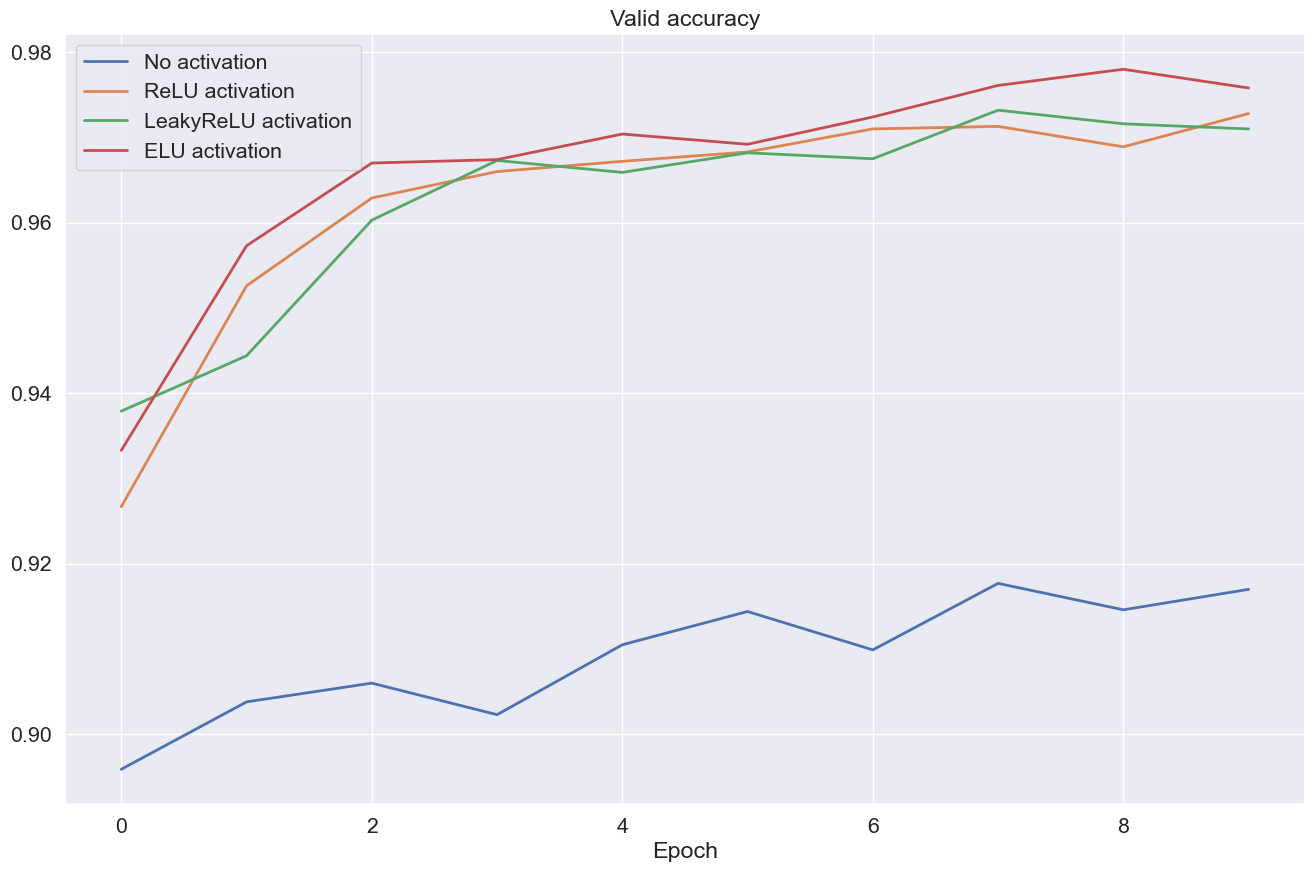

In [32]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy['valid'], label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy['valid'], label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

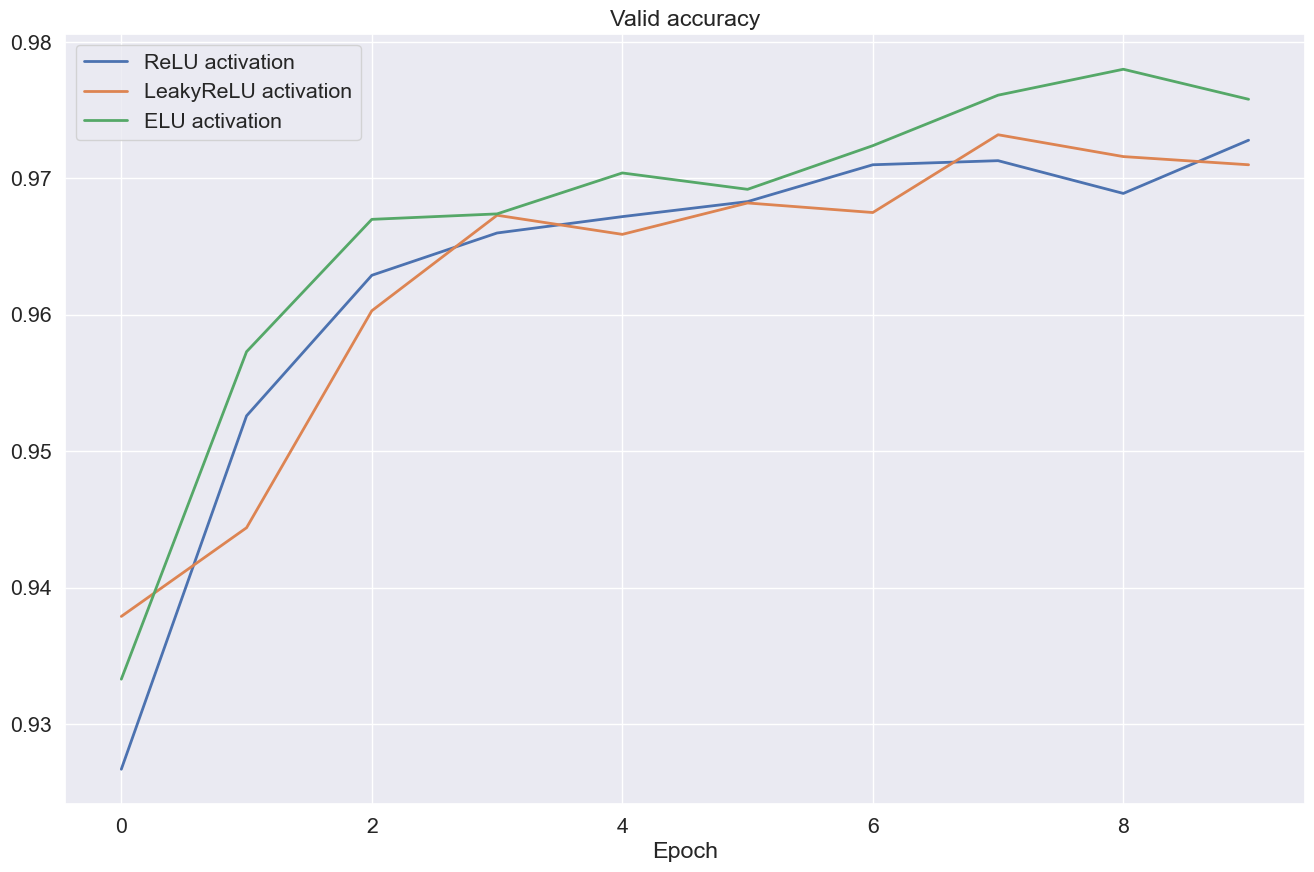

In [35]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy['valid'], label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


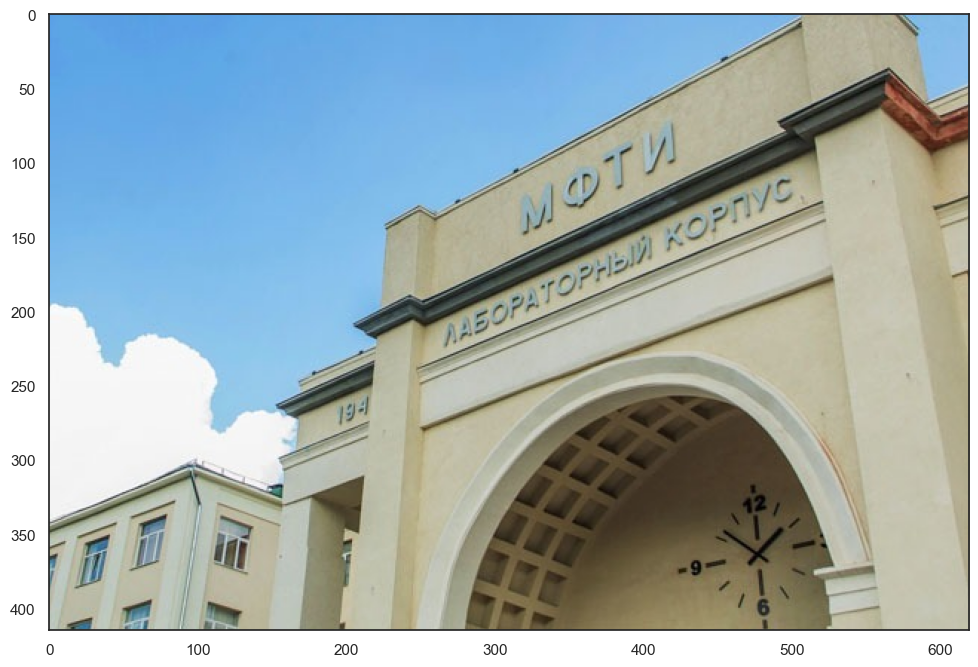

In [56]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [57]:
conv_1 = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]) # A
conv_2 = np.array([[0, 1, 0], [0, -2, 0], [0, 1, 0]]) # Б
conv_3 = np.array([[0, 0, 0], [1, -2, 1], [0, 0, 0]]) # В
conv_4 = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]]) # Г
conv_5 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) # Д
conv_6 = np.array([[0.0625, 0.125, 0.0625], [0.125, 0.25, 0.125], [0.0625, 0.125, 0.0625]]) # E

In [58]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor(conv_6).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

In [59]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.76692706..0.81901044].


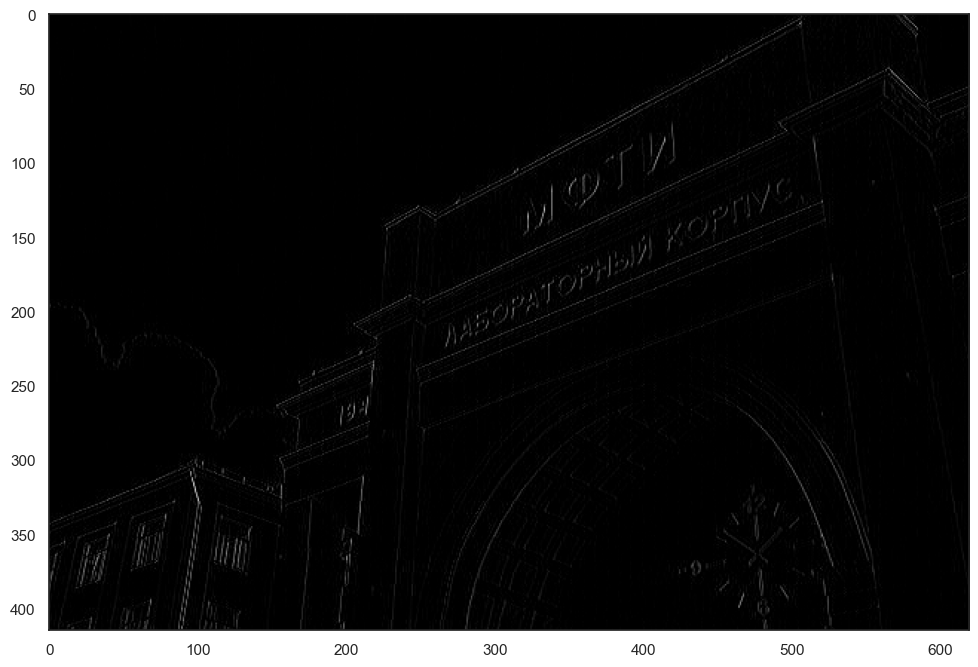

In [60]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Слой 1: Свертка 1 входной канал → 6 выходных, ядро 3x3
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        # Слой 2: Свертка 6 → 16, ядро 3x3
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        # Слой 3: Полносвязный слой 400 → 120 (зависит от размера входного изображения)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        # Слой 4: Полносвязный слой 120 → 84
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        # Слой 5: Выходной слой 84 → 10
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        # Уплощение
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = F.relu(self.conv1(x))     # Свертка + ReLU
        x = F.max_pool2d(x, 2)        # MaxPooling 2x2
        x = F.relu(self.conv2(x))     # Свертка + ReLU
        x = F.max_pool2d(x, 2)        # MaxPooling 2x2
        x = self.flatten(x)           # Уплощение
        x = F.relu(self.fc1(x))       # Полносвязный + ReLU
        x = F.relu(self.fc2(x))       # Полносвязный + ReLU
        x = self.fc3(x)               # Выходной слой
        return x

SyntaxError: invalid syntax (2379283441.py, line 6)

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [ ]:
#YOUR CODE

In [ ]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**